# Data Acquiring

In [1]:
import zipfile
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [2]:
import os
data_dir = "Alzheimer_s Dataset"
print(os.listdir(data_dir))

['test', 'train']


In [3]:
data_dir += "/train"
print(os.listdir(data_dir))
#C:/Users/acayt/Documents/GitHub/Brain-MRI-Alzheimers-Prediction/Alzheimer_s Dataset/train

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


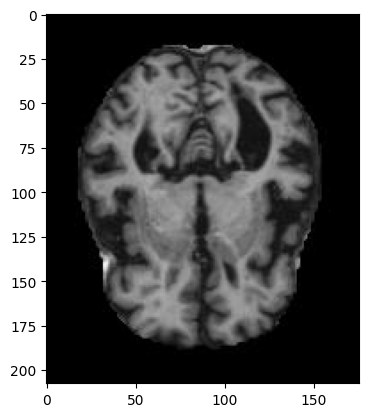

In [4]:
temp_dir = data_dir + "/MildDemented"

import cv2
import matplotlib.pyplot as plt

for img in os.listdir(temp_dir):
    img_array = cv2.imread(os.path.join(temp_dir, img))
    #print(img_array)
    plt.imshow(img_array)
    plt.show()
    break

In [5]:
print(img_array.shape)

(208, 176, 3)


# Data Preprocessing

In [ ]:
import tensorflow as tf

In [ ]:
# to augment images and create more samples

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(brightness_range=[0.8, 1.2], zoom_range=[0.99, 1.01], horizontal_flip=True, fill_mode="constant", data_format="channels_last")

In [8]:
train_data_gen = image_generator.flow_from_directory(directory=data_dir, target_size=(176, 176), batch_size=6500, shuffle=False)

Found 5121 images belonging to 4 classes.


In [9]:
import numpy as np
from random import randint

In [10]:
classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

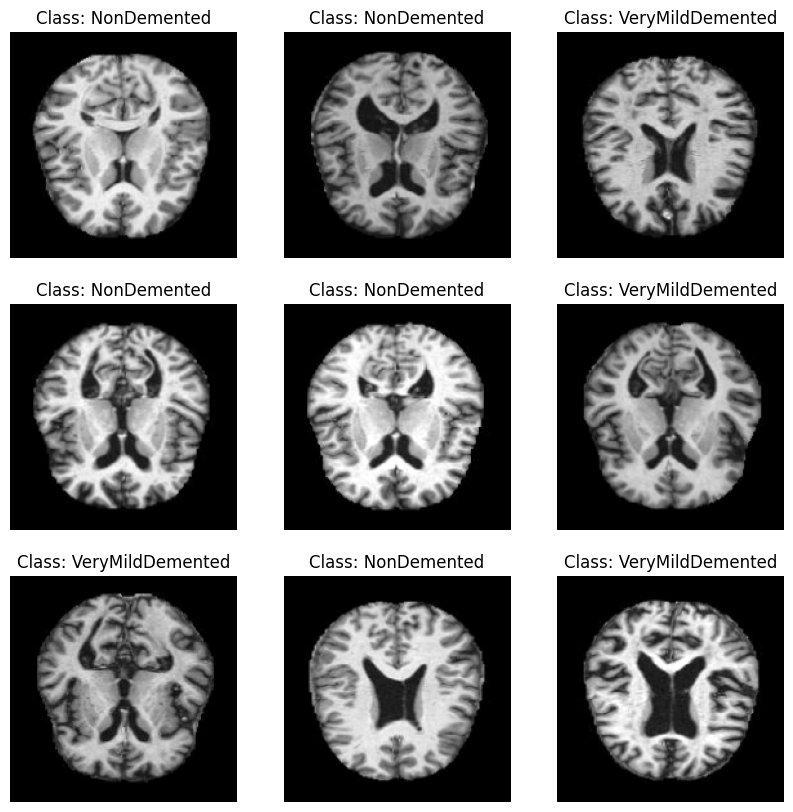

In [11]:
def show_images(generator, y_pred=None):
    # Input: An image generator, predicted labels (optional)
    # Output: Displays a grid of 9 random images with labels
    
    # get image labels
    labels = dict(zip([0, 1, 2, 3], classes))
    
    # get a batch of images
    x, y = next(generator)
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, len(x) - 1)  # corrected to use the length of x
            plt.imshow(x[idx].astype('uint8'))  # ensure the images are in the correct dtype
            plt.axis("off")
            plt.title("Class: {}".format(labels[np.argmax(y[idx])]))
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i].astype('uint8'))
            plt.axis("off")
            plt.title("Actual: {} \nPredicted: {}".format(labels[np.argmax(y[i])], labels[y_pred[i]]))
    
    plt.show()

# Display Train Images
show_images(train_data_gen)

In [12]:
train_data, train_labels = next(train_data_gen)
print(train_data.shape, train_labels.shape)

(5121, 176, 176, 3) (5121, 4)


In [13]:


























































































































































































































































































































































































































































































































































































for alzheimers_class in classes:
    container = []
    temp_dir = data_dir + "/" + alzheimers_class
    for file in os.listdir(temp_dir):
        container.append(file)
    print(alzheimers_class, ": ", len(container))

MildDemented :  717
ModerateDemented :  52
NonDemented :  2560
VeryMildDemented :  1792


The number of data samples for 'ModerateDemented' is considerably low, compared to the other classes. A clear contrast between the sizes of the training classes shows how imbalanced our classes are. So we'll need to perform over-sampling of the data using SMOTE.

In [14]:
import imblearn

sm = imblearn.over_sampling.SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 176 * 176 * 3), train_labels)
train_data = train_data.reshape(-1, 176, 176, 3)
print(train_data.shape, train_labels.shape)

(10240, 176, 176, 3) (10240, 4)


# Model Training

Going to use multiple types of blocks, multiple times. So I'm just going to define functions for each type of blocks and call them later.

### Convolutional Blocks

In [20]:
def conv_block(filters, act='relu'):    
    block = tf.keras.Sequential()
    block.add(tf.keras.layers.Conv2D(filters, 3, activation=act, padding='same'))
    block.add(tf.keras.layers.Conv2D(filters, 3, activation=act, padding='same'))
    block.add(tf.keras.layers.BatchNormalization())
    block.add(tf.keras.layers.MaxPool2D())
    
    return block

### Normalization Blocks

In [21]:
def norm_block(units, dropout_rate, act='relu'):    
    block = tf.keras.Sequential()
    block.add(tf.keras.layers.Dense(units, activation=act))
    block.add(tf.keras.layers.BatchNormalization())
    block.add(tf.keras.layers.Dropout(dropout_rate))
    
    return block

### Sequential Model

In [17]:
def construct_model(act='relu'):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*[176, 176], 3)),
        tf.keras.layers.Conv2D(16, 3, activation=act, padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation=act, padding='same'),
        tf.keras.layers.MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        norm_block(512, 0.7),
        norm_block(128, 0.5),
        norm_block(64, 0.3),
        tf.keras.layers.Dense(4, activation='softmax') #Output Layer       
    ], name = "cnn_model")

    return model

### Model Compilation

In [18]:
model = construct_model()

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc')]
    
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 176, 176, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 176, 176, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 88, 88, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 44, 44, 32)     │        14,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 22, 22, 64)     │        55,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 11, 11, 128)    │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 5, 5, 256)      │       886,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 512)            │     3,279,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 128)            │        66,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,534,996 (17.30 MB)

 Trainable params: 4,532,628 (17.29 MB)

 Non-trainable params: 2,368 (9.25 KB)

### Model Training

In [19]:
history = model.fit(train_data, train_labels, epochs=1, validation_split=0.2)

KeyboardInterrupt: 

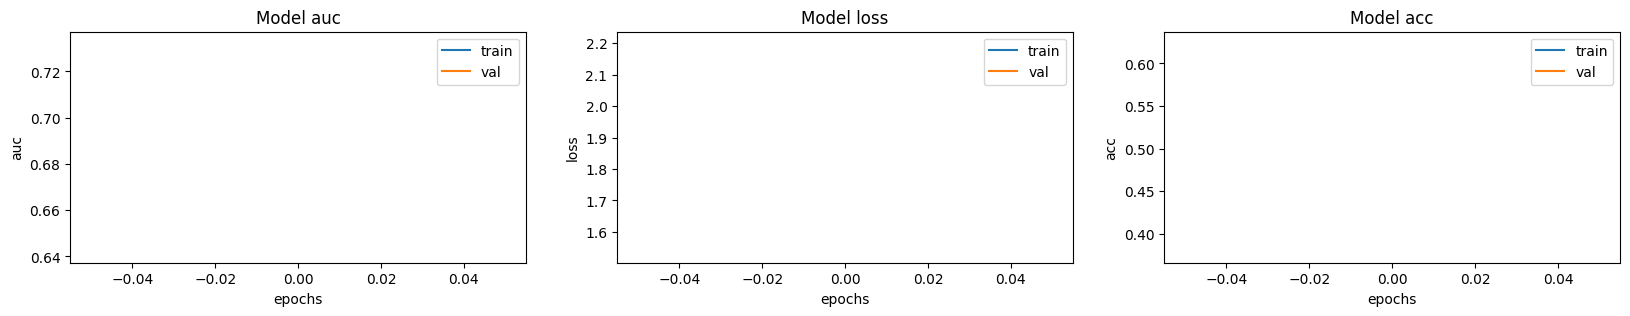

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss', 'acc']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### Model Testing

In [ ]:
data_dir1 = data_dir[:19]+'/test'
data_dir1

'Alzheimer_s Dataset/test'

In [ ]:
test_data_gen = image_generator.flow_from_directory(directory=data_dir1, target_size=(176, 176), batch_size=6500, shuffle=False)

Found 1279 images belonging to 4 classes.


In [ ]:
test_data, test_labels = next(test_data_gen)
print(test_data.shape, test_labels.shape)

(1279, 176, 176, 3) (1279, 4)


In [ ]:
test_scores = model.evaluate(test_data, test_labels)
print(test_scores)


40/40 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - acc: 0.0185 - auc: 0.3196 - loss: 5.1365
[5.4624762535095215, 0.009382329881191254, 0.22481074929237366]


In [ ]:
predicted_test_labels = model.predict(test_data)

40/40 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step


In [ ]:
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in predicted_test_labels:
    labels = roundoff(labels)

In [ ]:
import sklearn

print(sklearn.metrics.classification_report(test_labels, predicted_test_labels, target_names=classes))

                  precision    recall  f1-score   support

    MildDemented       0.00      0.00      0.00       179
ModerateDemented       0.01      1.00      0.02        12
     NonDemented       0.00      0.00      0.00       640
VeryMildDemented       0.00      0.00      0.00       448

       micro avg       0.01      0.01      0.01      1279
       macro avg       0.00      0.25      0.00      1279
    weighted avg       0.00      0.01      0.00      1279
     samples avg       0.01      0.01      0.01      1279



C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


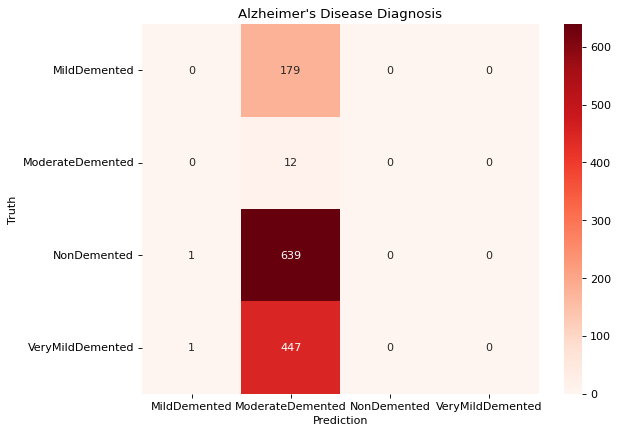

In [ ]:
pred_ls = np.argmax(predicted_test_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = sklearn.metrics.confusion_matrix(test_ls, pred_ls)
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

import seaborn as sns
ax = sns.heatmap(conf_arr, cmap='Reds', annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [22]:
model.save('model.h5')

